# Visualize MSH simulated depth through space and time

In [10]:
import os
import sys
import subprocess

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True
    root = r"/content/t-route"
    subprocess.run(
        [
            "git",
            "clone",
            "-b",
            "msh-depth-viz",
            "https://github.com/awlostowski-noaa/t-route.git",
        ]
    )

    # change current working directory to /notebooks
    os.chdir("/content/t-route/notebooks")
    
except:
    ENV_IS_CL = False
    root = os.path.dirname(os.path.abspath(""))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import warnings
warnings.simplefilter("ignore")

In [8]:
# import MSH output data
data = pd.read_csv('../test/output/msh_test_result.csv')

# rename columns to something more intuitive
data = data.rename(columns={"n+ (time)": "time",
                             "I (segment)": "seg",
                             "j (reach)": "reach",
                             "adjusted & accum. Length": "Length",
                             "depth + z [m]": "depth_el",
                             "depth [m]": "depth",
                             "z (channel bottom elev) [m]": "btm_el",
                             "Q [cms]": "flow"})

# A 2-D color mesh plot

In [ ]:
def msh_viz_grid(data, parameter, reach, scaling):
    
    df = data[data.reach == reach]

    nrows = len(np.unique(df.seg))
    ncols = len(np.unique(df.time))

    Z = np.empty([nrows,ncols])

    for i in range(1,nrows+1):
        Z[i-1,:] = df[df.seg == i].loc[:,parameter]

    x = [0]+list(np.unique(df.time)) # time

    if reach == 3:
        y = [data[data.reach == 1].Length.max()] + list(np.unique(df.Length)) # space
    else: 
        y = [0] + list(np.unique(df.Length)) # space

    fig, ax = plt.subplots()
    if scaling == "global":
        vmin=data.loc[:,parameter].min()
        vmax=data.loc[:,parameter].max()
    if scaling == "local":
        vmin=df.loc[:,parameter].min()
        vmax=df.loc[:,parameter].max()
        
    im = ax.pcolormesh(x, y, Z, shading='flat', vmin=vmin, vmax=vmax)

    X, Y = np.meshgrid(x, y)
    ax.set_title("Reach-" + str(reach) + " " + parameter)
    plt.ylabel("Distance (m)")
    plt.xlabel("Time (units?)")
    fig.colorbar(im, ax=ax)

    plt.show()

    
# call function above
'''
function inputs:
parameter (str): the column title of the parameter you would like to visualize, must match exactly
reach (int): the reach number you would like to visualize
scaling (str): if "global", colorbar is scaled between network min and max; 
               if "local" clorbar is scaled between reach min and max
'''
msh_viz_grid(data, parameter = "depth", reach = 2, scaling = "global")

# Simple line plots showing changes in flow though time for all segments in a specified reach

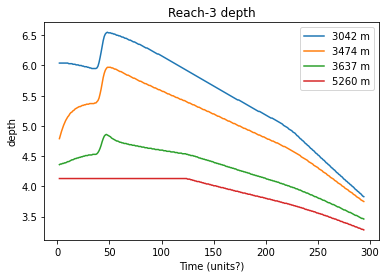

In [12]:
def msh_viz_lines(data, reach, parameter):

    df = data[data.reach == reach]

    fig, ax = plt.subplots()

    for key, grp in df.groupby(['Length']):
        ax = grp.plot(ax=ax, kind='line', x='time', y=parameter, label=str(key) + " m")

    ax.set_title("Reach-" + str(reach) + " " + parameter)
    plt.ylabel(parameter)
    plt.xlabel("Time (units?)")
    
    plt.show()

# call function above
'''
function inputs:
parameter (str): the column title of the parameter you would like to visualize, must match exactly
reach (int): the reach number you would like to visualize
'''
msh_viz_lines(data, parameter = "depth", reach = 3)

# An interactive plot showing longitudinal variations in depth and flow for each reach

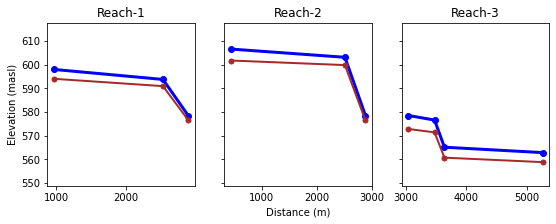

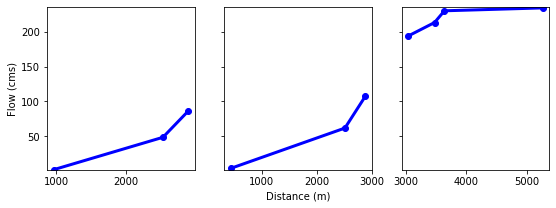

In [14]:
%matplotlib inline


def p(data, reach, t_step):
    
    time = data.loc[t_step,:].time

    # ************** DEPTH **********************
    fig, (ax1) = plt.subplots(1,3, figsize=(9, 3), sharey=True)
  
    df = data[data.reach == 1][data.time == time]
    ax1[0].plot( 'Length', 'depth_el', data=df, marker='o', markerfacecolor='blue', markersize=6, color='blue', linewidth=3)
    ax1[0].plot( 'Length', 'btm_el', data=df, marker='o', markerfacecolor='brown', markersize=5, color='brown', linewidth=2)
    plt.setp(ax1[0], title='Reach-1')
    
    df = data[data.reach == 2][data.time == time]
    ax1[1].plot( 'Length', 'depth_el', data=df, marker='o', markerfacecolor='blue', markersize=6, color='blue', linewidth=3)
    ax1[1].plot( 'Length', 'btm_el', data=df, marker='o', markerfacecolor='brown', markersize=5, color='brown', linewidth=2)
    plt.setp(ax1[1], title='Reach-2')
    
    df = data[data.reach == 3][data.time == time]
    ax1[2].plot( 'Length', 'depth_el', data=df, marker='o', markerfacecolor='blue', markersize=6, color='blue', linewidth=3)
    ax1[2].plot( 'Length', 'btm_el', data=df, marker='o', markerfacecolor='brown', markersize=5, color='brown', linewidth=2)
    plt.setp(ax1[2], title='Reach-3')
    
    plt.ylim([data.btm_el.min()-10,data.depth_el.max()+10])
    plt.setp(ax1[0], ylabel='Elevation (masl)')

    plt.setp(ax1[1], xlabel='Distance (m)')
    plt.show()

    # ************** FLOW **********************
    fig, (ax2) = plt.subplots(1,3, figsize=(9, 3), sharey=True)

    df = data[data.reach == 1][data.time == time]
    ax2[0].plot( 'Length', 'flow', data=df, marker='o', markerfacecolor='blue', markersize=6, color='blue', linewidth=3)

    df = data[data.reach == 2][data.time == time]
    ax2[1].plot( 'Length', 'flow', data=df, marker='o', markerfacecolor='blue', markersize=6, color='blue', linewidth=3)

    df = data[data.reach == 3][data.time == time]
    ax2[2].plot( 'Length', 'flow', data=df, marker='o', markerfacecolor='blue', markersize=6, color='blue', linewidth=3)

    plt.setp(ax2[0], ylabel='Flow (cms)')
    plt.setp(ax2[1], xlabel='Distance (m)')
    plt.ylim([data.flow.min(), data.flow.max()])

interactive_plot = interactive(p, data = fixed(data), reach = fixed(1), t_step=(data.index.min(),data.index.max(),1))

output = interactive_plot.children[-1]
interactive_plot